#### Structure of the data: anonymized_project.json
```json
{
    "results": {
        "root_node": {
            "gui_type": "discrete_answer",
            "results": {
                "7e8984b6-dff7-4015-865a-b721a2faf681": {
                    "results": [
                        {
                            "task_input": {
                                "image_url": "https://qm-auto-annotator.s3.eu-central-1.amazonaws.com/bicycles/img_4686.jpg"
                            },
                            "created_at": "2021-02-25T14:08:11.319438+00:00",
                            "workpackage_total_size": 5,
                            "loss": 0.0,
                            "project_node_input_id": "7e8984b6-dff7-4015-865a-b721a2faf681",
                            "project_node_output_id": "0000439a-96ac-4bd4-8753-a4baa229ecf2",
                            "task_output": {
                                "answer": "no",
                                "cant_solve": false,
                                "corrupt_data": false,
                                "duration_ms": 997
                            },
                            "user": {
                                "vendor_id": "vendor_01",
                                "id": "08af8775-a72c-4c59-b60f-9ce7df04fa92",
                                "vendor_user_id": "annotator_12"
                            },
                            "root_input": {
                                "image_url": "https://qm-auto-annotator.s3.eu-central-1.amazonaws.com/bicycles/img_4686.jpg"
                            },
                            "project_root_node_input_id": "7e8984b6-dff7-4015-865a-b721a2faf681"
                        },
                        ...(8)
                       {
                        ...
                        }
                     ],
                     "gui_type": "discrete_answer"
                 },
                    ...(9085)
                "7e8984b6-dff7-4015-865a-b721a2faf681": {
                    "results": [
                        ...(10)
                     ],
                     "gui_type": "discrete_answer"
                 }
            }
        }
    }
}
```

#### Structure of the data: references.json
```json
{
  "img_4686": { "is_bicycle": false },
    ...(9085)
  "img_2866": { "is_bicycle": true }
}
```

In [11]:
'''
import json
import pandas as pd

dff = pd.read_json('anonymized_project.json')

# 使用 Python JSON 模块载入数据
with open('anonymized_project.json','r') as ff:
    dataa = json.loads(ff.read())

# 展平数据
df_nested = pd.json_normalize(dataa, record_path =['results'])

'''

"\nimport json\nimport pandas as pd\n\ndff = pd.read_json('anonymized_project.json')\n\n# 使用 Python JSON 模块载入数据\nwith open('anonymized_project.json','r') as ff:\n    dataa = json.loads(ff.read())\n\n# 展平数据\ndf_nested = pd.json_normalize(dataa, record_path =['results'])\n\n"

In [ ]:


# 使用 Python JSON 模块载入数据
with open('anonymized_project.json','r') as ff:
    dataa = json.loads(ff.read())

# 展平数据
df_nested = pd.json_normalize(dataa, record_path =['results'])


In [12]:
import os
import time
import pandas as pd
import numpy as np
import random
import json
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from time import time
from sklearn.metrics import confusion_matrix


In [13]:
# pip install pandas==1.1.3

In [14]:
# find files of certain type under the current path
def find_file(kw='json'):
    path = os.getcwd()
    # list of all files
    content = os.listdir(path)
    f_list = []
    for file in content:
        if kw in file:
            f_list.append(file)
            
    return f_list

# list of json files unter the path
json_list = find_file('json')

print("There are {0} json-files available: {1[0]} and {1[1]}".format(len(json_list), json_list))

There are 2 json-files available: anonymized_project.json and references.json


In [15]:
# read anonymized_project.json
with open(json_list[0], 'r') as f1:
    anno = json.load(f1)
    
# read references.json
with open(json_list[1], 'r') as f2:
    ref = json.load(f2)

# dict, length 1
result = anno['results']
# dict, length 2
root = result['root_node']
# dict, length 9087
crowds = root['results']

print("Number of crowds: {}".format(len(crowds)))
print("Number of references: {}".format(len(ref)))

Number of crowds: 9087
Number of references: 9087


In [16]:
# extract the needed information from each task
def crowd_extractor(crowd):
    '''
    A crowd object must be a dictionary under the root_node['results'], which contains 10 
    tasks/annotations as it's own 'result'. Tasks are contained in a LIST under the chosen 
    crowd. 
    For example: 
    A crowd: crowds['7e8984b6-dff7-4015-865a-b721a2faf681'] contains 10 tasks (dictionary), 
    which are contained in list: crowds['7e8984b6-dff7-4015-865a-b721a2faf681']['results'].
    The output of this function is a 'list of lists' with needed information about the 
    tasks/annoations under the input crowd.
    '''
    crowd_info = []
    
    for task in crowd['results']:
        # extract information of the task
        url = task['task_input']['image_url']
        image = url.replace(
            'https://qm-auto-annotator.s3.eu-central-1.amazonaws.com/bicycles/', ''
        ).replace(
            '.jpg', ''
        )
        # name of annotators
        user = task['user']['vendor_user_id']
        # 'yes/no' to '1/0', NaN if no answer
        answer = task['task_output']['answer']
        # 'True/False' to '1/0'
        solvable = int(not task['task_output']['cant_solve'])
        corrupt = int(task['task_output']['corrupt_data'])
        # duration in millisecond
        duration = int(task['task_output']['duration_ms'])
        # collect the information
        task_info = [
            image,
            user,
            answer,
            solvable,
            corrupt,
            duration
        ]
        # add to upper list
        crowd_info.append(task_info)
    
    return crowd_info


# iterate over all crowds and build a DataFrame
def build_data(crowds=crowds, ref=ref):
    '''
    The crowds object here means the root_node['results'], which contains 9087 dictionaries 
    (crowd). Each crowd has its own individual key
    For example: 
    A crowd: crowds['7e8984b6-dff7-4015-865a-b721a2faf681'] contains 10 tasks (dictionary), 
    which are contained in list: crowds['7e8984b6-dff7-4015-865a-b721a2faf681']['results'].
    The output of this function is a 'pandas.DataFrame' with needed information from the 
    hole data set.
    '''
    info = []
    #set up timer
    start = time()
    total = len(crowds.keys())
    i = 0
    
    for key in crowds.keys():
        i += 1
        percent = round(1.0 * i / total * 100, 2)
        # extract crowd information
        crowd = crowds[str(key)]
        crowd_info = crowd_extractor(crowd)
        info.extend(crowd_info)
        print(
            "Processing crowd: {0}, {1} [{2}/{3}]".format(key, str(percent)+'%', i, total), 
            end="\r"
        )
        #time.sleep(0.01)
    print("Processing done! {:.2f} seconds passed.".format((time() - start)), end="\r")
    
    # build DataFrame
    result = pd.DataFrame(
        info, columns=[
            'image','user','answer','solvable','corrupt','duration'
        ]
    )
    # quantify the answers
    num_encode = {"answer": {"yes": 1, "no": 0, "": np.nan}}
    result.replace(num_encode, inplace=True)
    # add column of references
    result['reference'] = result.apply(
        lambda x: int(ref[x['image']]['is_bicycle']), 
        axis=1
    )
    # add column of correctness
    result['correct'] = result.apply(
        lambda x: int(x['answer']==x['reference']),
        axis=1
    )
    
    return result


# build the DataFrame
data_full = build_data()

In [17]:
data_full.sample(5)

,image,user,answer,solvable,corrupt,duration,reference,correct
76608,img_0317,annotator_12,1.0,1,0,900,1,1
81905,img_2346,annotator_06,0.0,1,0,1024,0,1
74041,img_8704,annotator_04,0.0,1,0,1257,0,1
8268,img_3499,annotator_08,0.0,1,0,1609,0,1
75291,img_6708,annotator_11,0.0,1,0,1271,0,1


In [18]:
# check out the data set
print("Basic information of the loaded data:\n")
print(data_full.info())

Basic information of the loaded data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90870 entries, 0 to 90869
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      90870 non-null  object 
 1   user       90870 non-null  object 
 2   answer     90849 non-null  float64
 3   solvable   90870 non-null  int64  
 4   corrupt    90870 non-null  int64  
 5   duration   90870 non-null  int64  
 6   reference  90870 non-null  int64  
 7   correct    90870 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.5+ MB
None


In [19]:
# anootations without available answer
n_nan = len(data_full[data_full['answer'].isnull()==True])
# drop the rows without available answer (90849 left)
data = data_full.dropna(subset=['answer'])

print("There are {} annotation(s) without available answer.".format(n_nan))

There are 21 annotation(s) without available answer.


In [20]:
#data_full[data_full['answer'].isnull()==True]

In [21]:
# check out the values
print("Basic information of the loaded data:\n")
print(data_full.describe())

Basic information of the loaded data:

             answer      solvable       corrupt      duration     reference  \
count  90849.000000  90870.000000  90870.000000  90870.000000  90870.000000   
mean       0.507788      0.999813      0.000044   1284.333873      0.504677   
std        0.499942      0.013677      0.006635   1351.960465      0.499981   
min        0.000000      0.000000      0.000000 -99999.000000      0.000000   
25%        0.000000      1.000000      0.000000    887.000000      0.000000   
50%        1.000000      1.000000      0.000000   1058.000000      1.000000   
75%        1.000000      1.000000      0.000000   1328.000000      1.000000   
max        1.000000      1.000000      1.000000  42398.000000      1.000000   

            correct  
count  90870.000000  
mean       0.934676  
std        0.247098  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000  


In [22]:
#n_bad_dura = sum(d<=0 for d in list(data['duration']))
n_bad_dura = len(data_full.loc[data_full['duration']<=0])

print("There are {} annotation(s) with non-positive duration, which should be replaced.".format(n_bad_dura))

There are 6 annotation(s) with non-positive duration, which should be replaced.


In [23]:
# fix the non-positive durations
def fix_negativ(df=data, inst='user', targ='duration'):
    '''
    Replace the non-positive value with the average of positive values
    of column 'duration' for each 'user'.
    '''
    # make a copy of the DataFrame
    df_new = df.copy(deep=True)
    # deduplication by chosen column
    inst_list = list(set(df_new[inst]))
    
    for i in inst_list: 
        df_sl = df_new.loc[df_new[inst]==str(i)]
        # index of non-positive values
        neg_ind = list(df_sl.loc[(df_sl[targ]<=0)].index)
        # mean of normal values
        mean = df_sl[~(df_sl[targ]<=0)][targ].mean()
        df_new.loc[neg_ind, targ] = mean
        
    return df_new


# fix the bad values
data_fix = fix_negativ()

array([[<AxesSubplot:xlabel='answer', ylabel='answer'>,
        <AxesSubplot:xlabel='solvable', ylabel='answer'>,
        <AxesSubplot:xlabel='corrupt', ylabel='answer'>,
        <AxesSubplot:xlabel='duration', ylabel='answer'>,
        <AxesSubplot:xlabel='reference', ylabel='answer'>,
        <AxesSubplot:xlabel='correct', ylabel='answer'>],
       [<AxesSubplot:xlabel='answer', ylabel='solvable'>,
        <AxesSubplot:xlabel='solvable', ylabel='solvable'>,
        <AxesSubplot:xlabel='corrupt', ylabel='solvable'>,
        <AxesSubplot:xlabel='duration', ylabel='solvable'>,
        <AxesSubplot:xlabel='reference', ylabel='solvable'>,
        <AxesSubplot:xlabel='correct', ylabel='solvable'>],
       [<AxesSubplot:xlabel='answer', ylabel='corrupt'>,
        <AxesSubplot:xlabel='solvable', ylabel='corrupt'>,
        <AxesSubplot:xlabel='corrupt', ylabel='corrupt'>,
        <AxesSubplot:xlabel='duration', ylabel='corrupt'>,
        <AxesSubplot:xlabel='reference', ylabel='corrupt'>,
   

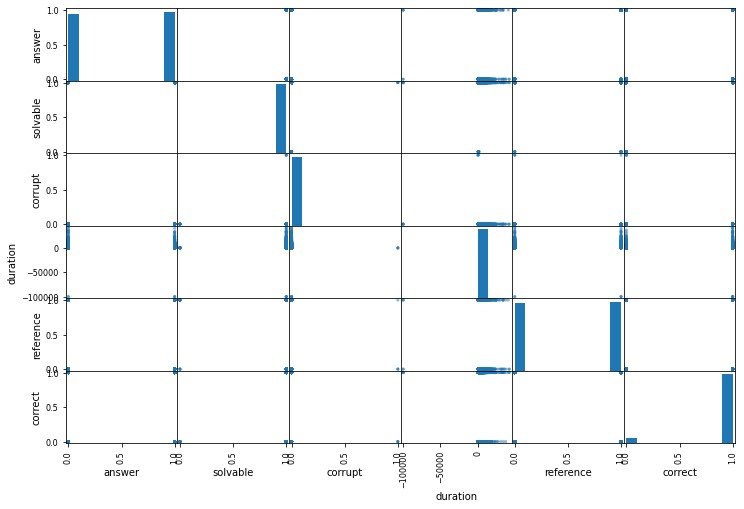

In [83]:

from pandas.plotting import scatter_matrix

scatter_matrix(data_full, figsize=(12, 8))

In [79]:
data_full['solvable'].value_counts()

1    90853
0       17
Name: solvable, dtype: int64

In [61]:
corr_matrix = data.corr()

In [62]:
corr_matrix

,answer,solvable,corrupt,duration,reference,correct
answer,1.000000,NaN,NaN,-0.041194,0.869782,-0.008606
solvable,NaN,NaN,NaN,NaN,NaN,NaN
corrupt,NaN,NaN,NaN,NaN,NaN,NaN
duration,-0.041194,NaN,NaN,1.000000,-0.045182,-0.062607
reference,0.869782,NaN,NaN,-0.045182,1.000000,0.015171
correct,-0.008606,NaN,NaN,-0.062607,0.015171,1.000000


In [80]:
data_full['corrupt'].value_counts()

0    90866
1        4
Name: corrupt, dtype: int64

In [59]:
data_full['answer'].value_counts()

1.0    46132
0.0    44717
Name: answer, dtype: int64

In [24]:
# get statistical information by annotator or images/questions
def statistic_master(df=data_fix, col='user'):
    '''
    This function is used to get statistic information from the data set, like:
        - amount of annotations by selected category
        - amount of positive annotations
        - amount of correct annotations
        - accuracy of annotation by selected category
        - average duration
        - precision
        - recall
    Argument col could take 'user' or 'image'
    The output is a pandas.DataFrame.
    '''
    info = []
    
    # deduplication of chosen column and sort 
    inst_list = list(set(df[col]))
    inst_list.sort()
    # set up timer
    start = time()
    total = len(inst_list)
    t = 0
    print("Start processing statistic...It will take a while.")
    
    for inst in inst_list:
        t += 1
        p = round(1.0 * t / total * 100, 2)
        
        # collect the statistic informations
        amo_tot = len(df.loc[df[col]==inst])
        amo_pos = int(df['answer'].loc[df[col]==inst].sum())
        amo_corre = int(df['correct'].loc[df[col]==inst].sum())
        avg_dura = round(df['duration'].loc[df[col]==inst].mean(), 2)
        accu = round(df['correct'].loc[df[col]==inst].mean(), 2)
        # save in list
        inst_info = [inst, amo_tot, amo_pos, amo_corre, avg_dura, accu]
        # optional infomation
        if col=='user':
            y_anno = list(df['answer'].loc[df[col]==inst])
            y_true = list(df['reference'].loc[df[col]==inst])
            tn, fp, fn, tp = confusion_matrix(y_true, y_anno).ravel()
            prec = round(tp/(tp+fp), 2)
            rec = round(tp/(tp+fn), 2)
            #accu = round((tp+tn)/(tn+fp+fn+tp), 2)
            inst_info.extend([prec, rec])
        if col=='image':
            ref = df['reference'].loc[df[col]==inst].mean()
            inst_info.append(ref)
        
        info.append(inst_info)
        print("Processing: {0}, {1} [{2}/{3}]".format(inst, str(p)+'%', t, total), end="\r")
        #time.sleep(0.01)
        
    print("Processing done! {:.2f} seconds passed.".format((time() - start)), end="\r")
    
    # save in DataFrame
    if col=='user':
        columns = [
            col, 
            'total amount', 
            'positive amount', 
            'correct amount', 
            'avg.duration', 
            'accuracy', 
            'precision', 
            'recall'
        ]
    if col=='image':
        columns = [
            col, 
            'total amount', 
            'positive amount', 
            'correct amount', 
            'avg.duration', 
            'accuracy',
            'reference'
        ]
    result = pd.DataFrame(info, columns=columns)
    '''
    # add percent sign
    result.loc[:, 'accuracy'] = result.loc[:, 'accuracy'].apply(
        lambda x: "{:.2f}%".format(x)
    )
    '''
    
    return result


************************

### How many annotators did contribute to the dataset?

In [25]:
# deduplication by 'user'
user_list = list(set(data_full['user']))
user_list.sort()

print("There are {} annotators in total did contribute to the dataset.".format(len(user_list)))

There are 22 annotators in total did contribute to the dataset.


In [48]:
data_full['user'].value_counts()

annotator_02    7596
annotator_13    7078
annotator_08    6537
annotator_11    6436
annotator_04    6421
annotator_12    6210
annotator_20    6126
annotator_15    6088
annotator_06    5337
annotator_18    5170
annotator_16    5061
annotator_09    4860
annotator_17    3485
annotator_05    3475
annotator_21    2950
annotator_07    2175
annotator_22    1745
annotator_14    1725
annotator_01    1280
annotator_03     630
annotator_10     315
annotator_19     170
Name: user, dtype: int64

************************

###  Did all annotators produce the same amount of results, or are there differences?

In [26]:
# get amount of results for each annotators
print("Amount of results contributed by each annotator:\n")
print(data_full.groupby(['user'],as_index=False).size())

Amount of results contributed by each annotator:

            user  size
0   annotator_01  1280
1   annotator_02  7596
2   annotator_03   630
3   annotator_04  6421
4   annotator_05  3475
5   annotator_06  5337
6   annotator_07  2175
7   annotator_08  6537
8   annotator_09  4860
9   annotator_10   315
10  annotator_11  6436
11  annotator_12  6210
12  annotator_13  7078
13  annotator_14  1725
14  annotator_15  6088
15  annotator_16  5061
16  annotator_17  3485
17  annotator_18  5170
18  annotator_19   170
19  annotator_20  6126
20  annotator_21  2950
21  annotator_22  1745


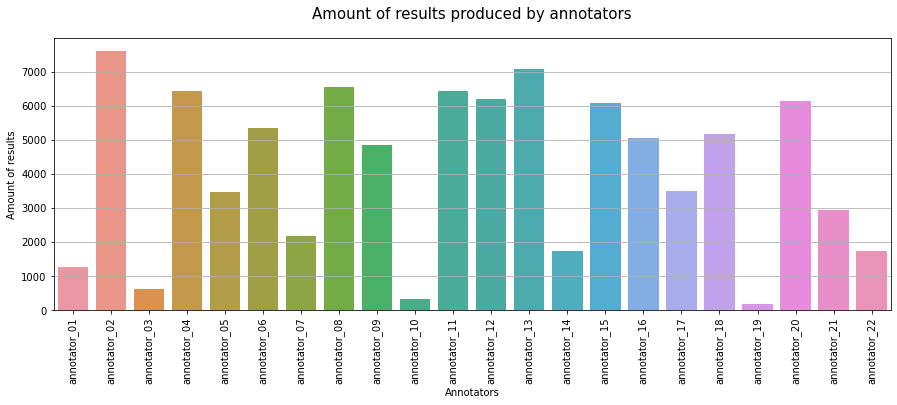

In [27]:
# visualize the amounts of results
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Amount of results produced by annotators", y=1.05, size=15)
sns.countplot(x='user', data=data_full.sort_values(by='user'))
ax.set_xlabel('Annotators', fontsize=10)
ax.set_ylabel('Amount of results', fontsize=10)
ax.xaxis.set_tick_params(rotation=90)
ax.grid(axis='y')
plt.show()


************************

### Are there questions for which annotators highly disagree?

In [28]:
# get statistic for images
stats_image = statistic_master(data_fix, col='image')

Start processing statistic...It will take a while.


In [29]:
#stats_image.sample(5)

In [30]:
# amount of images, to those not a single annotator gave a positive answer
n_disagree = len(stats_image.loc[stats_image['positive amount']==0])
n_fn = len(stats_image.loc[(stats_image['positive amount']==0) & (stats_image['accuracy']==0)])

print("There are {} images/questions for which all annotators totally disagree.".format(n_disagree))
print("{} of the images/questions are incorrectly as negative annotated (false negative).".format(n_fn))

There are 3524 images/questions for which all annotators totally disagree.
88 of the images/questions are incorrectly as negative annotated (false negative).


In [31]:
print([im for im in list(stats_image['image'].loc[(stats_image['positive amount']==0) & (stats_image['accuracy']==0)])])

['img_0105', 'img_0179', 'img_0201', 'img_0220', 'img_0286', 'img_0332', 'img_0532', 'img_0576', 'img_0658', 'img_0809', 'img_1008', 'img_1047', 'img_1569', 'img_1570', 'img_1637', 'img_1684', 'img_1931', 'img_1945', 'img_2021', 'img_2068', 'img_2140', 'img_2340', 'img_2341', 'img_2436', 'img_2692', 'img_2716', 'img_2899', 'img_2999', 'img_3009', 'img_3148', 'img_3179', 'img_3266', 'img_3328', 'img_3352', 'img_3359', 'img_3468', 'img_3626', 'img_3896', 'img_3973', 'img_4009', 'img_4043', 'img_4065', 'img_4272', 'img_4403', 'img_4456', 'img_4489', 'img_4596', 'img_4600', 'img_5006', 'img_5529', 'img_5666', 'img_5777', 'img_5779', 'img_5845', 'img_5864', 'img_6047', 'img_6211', 'img_6240', 'img_6364', 'img_6399', 'img_6509', 'img_6655', 'img_6672', 'img_6816', 'img_6970', 'img_6980', 'img_7134', 'img_7174', 'img_7389', 'img_7531', 'img_7694', 'img_7880', 'img_7950', 'img_8048', 'img_8060', 'img_8158', 'img_8237', 'img_8272', 'img_8281', 'img_8510', 'img_8566', 'img_8569', 'img_8633', 'im

In [32]:
# runs very slow
'''
# visualize the amounts of results
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Amount of results produced by annotators", y=1.05, size=15)
sns.barplot(x='image', y='accuracy', data=stats_image)
ax.set_xlabel('Annotators', fontsize=10)
ax.set_ylabel('Amount of results', fontsize=10)
ax.xaxis.set_tick_params(rotation=90)
ax.grid(axis='y')
'''

'\n# visualize the amounts of results\nfig, ax = plt.subplots(figsize=(15,5))\nax.set_title("Amount of results produced by annotators", y=1.05, size=15)\nsns.barplot(x=\'image\', y=\'accuracy\', data=stats_image)\nax.set_xlabel(\'Annotators\', fontsize=10)\nax.set_ylabel(\'Amount of results\', fontsize=10)\nax.xaxis.set_tick_params(rotation=90)\nax.grid(axis=\'y\')\n'

### What are the average, min and max annotation times (durations)?

In [33]:
data_fix['duration'].describe()

count    90849.000000
mean      1290.050170
std       1124.059174
min         10.000000
25%        887.000000
50%       1058.000000
75%       1328.000000
max      42398.000000
Name: duration, dtype: float64

In [34]:
print("To the entire data set:")
print('-'*50)
print ("Median duration {:.2f} [ms]".format(data_fix['duration'].median()))
print ("Maximal duration {:.2f} [ms]".format(data_fix['duration'].max()))
print ("Minimal duration {:.2f} [ms]".format(data_fix['duration'].min()))
print ("Average duration {:.2f} [ms]".format(data_fix['duration'].mean()))

To the entire data set:
--------------------------------------------------
Median duration 1058.00 [ms]
Maximal duration 42398.00 [ms]
Minimal duration 10.00 [ms]
Average duration 1290.05 [ms]


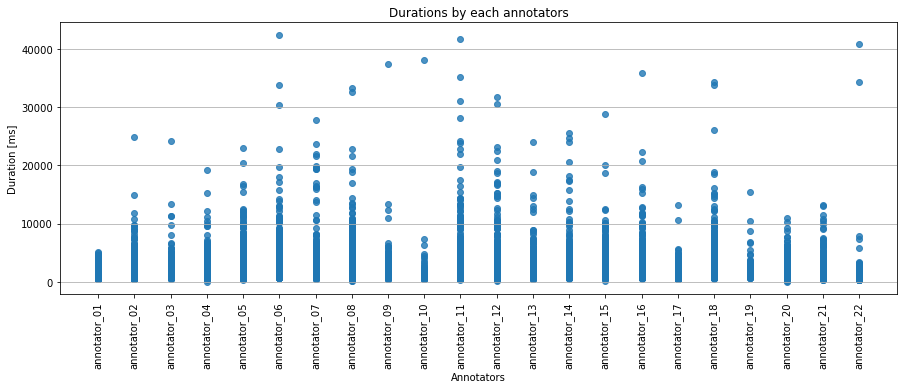

In [35]:
# visualize the durations
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('Durations by each annotators')
sns.regplot(x='user', y='duration', data=data_fix.sort_values(by='user'), fit_reg=False, ax=ax)
ax.set_xlabel('Annotators', fontsize=10)
ax.set_ylabel('Duration [ms]', fontsize=10)
ax.xaxis.set_tick_params(rotation=90)
ax.grid(axis='y')
plt.show()


************************

### How often does each occur in the project and do you see a trend within the annotators that made use of these options?

In [113]:
# Hint: the data_full has the original index

n = len(data_full)

# index of 'unsolvable' data 
ind_unsol = data_full.loc[data_full['solvable']==0].index.tolist()
n_unsol = len(ind_unsol)
# index of 'corrupted' data 
ind_corr = data_full.loc[data_full['corrupt']==1].index.tolist()
n_corr = len(ind_corr)
# index of data with no answer
ind_nans = data_full.loc[data_full['answer'].isnull()==True].index.tolist()
n_nans = len(ind_nans)


In [ ]:
#irre_ind = set().union(ind_nans, ind_unsol, ind_corr)

In [71]:
print("To the entire data set:")
print('-'*50)
print ("{0} annotations were unsolvable ({1}%)".format(n_unsol, round((n_unsol/n)*100, 4)))
print ("{0} annotations were corrupt ({1}%)".format(n_corr, round((n_corr/n)*100, 4)))

To the entire data set:
--------------------------------------------------
17 annotations were unsolvable (0.0187%)
4 annotations were corrupt (0.0044%)


In [138]:
#list(set(ind_nans).intersection(set(ind_corr)))

In [136]:
ind_corr_unsol = list(set(ind_unsol+ind_corr))
ind_corr_unsol.sort()
ind_coun = list(set(ind_unsol).intersection(set(ind_corr)))
ind_coun.sort()

if ind_corr_unsol == ind_nans:
    print("Annotations without answer are exactly the sum of unsolvable and corrupt annotations.")
elif len(ind_coun) != 0:
    print("Annotations, which are unsolvable and corrupt:\n", ind_coun)
else:
    ind_nans_sol = list(set(ind_nans).difference(set(ind_unsol)))
    print("Annotations without answer, which are solvable:\n", ind_nans_sol)
    ind_nans_nc = list(set(ind_nans).difference(set(ind_corr)))
    print("Annotations without answer, which are not corrupt:\n", ind_nans_nc)

Annotations without answer are exactly the sum of unsolvable and corrupt annotations.


In [37]:
#data_full.sort_values(by='user').loc[data_full['solvable']==0].index

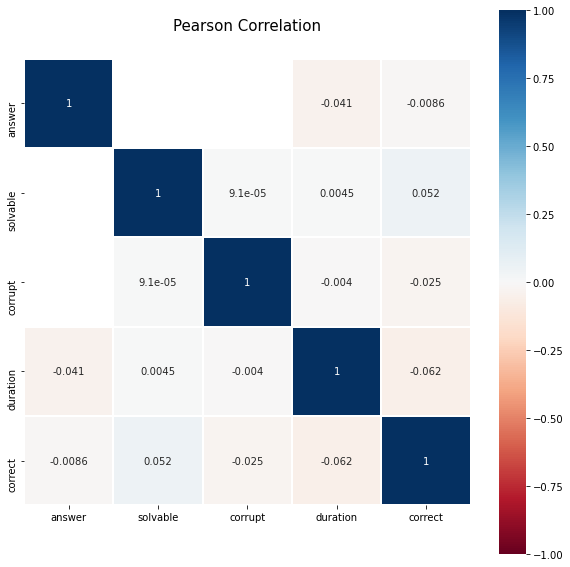

In [39]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation', y=1.05, size=15)
sns.heatmap(
    data_full[['answer','solvable','corrupt','duration','correct']].astype(float).corr(),
    linewidths=1,
    vmax=1.0, 
    vmin=-1.0, 
    square=True, 
    cmap=colormap, 
    linecolor='white', 
    annot=True)
plt.show()


************************

### Is the reference set balanced? Please demonstrate via numbers and visualizations.

In [40]:
# about the balance of reference
n_true = list(data_full['reference']).count(1)
true_rate = n_true/len(data_full)

# I'm not sure about this range
if true_rate>=0.33 and true_rate<=0.66:
    jug = 'balanced'
else:
    jug = 'unbalanced'

print("There are {0} positive samples in the reference,which is {1}% of the hole data set.".format(n_true, round(true_rate*100,2)))
print("The reference is {0}.".format(jug))

There are 45860 positive samples in the reference,which is 50.47% of the hole data set.
The reference is balanced.


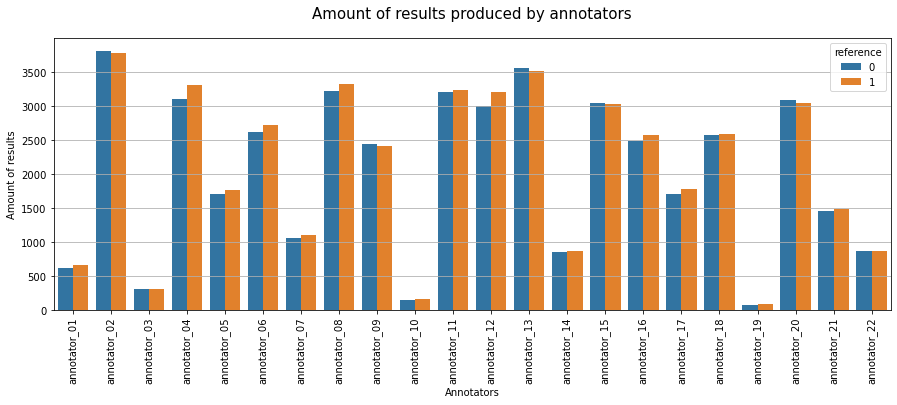

In [41]:
# visualize the amounts of results
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Amount of results produced by annotators", y=1.05, size=15)
sns.countplot(x='user', hue='reference', data=data_full.sort_values(by='user'))
ax.set_xlabel('Annotators', fontsize=10)
ax.set_ylabel('Amount of results', fontsize=10)
ax.xaxis.set_tick_params(rotation=90)
ax.grid(axis='y')
plt.show()


************************

### Using the reference set, can you identify good and bad annotators?  Please use statistics and visualizations.

In [42]:
# get statistical information for users
stats_user = statistic_master(data_fix, col='user')

Start processing statistic...It will take a while.


In [78]:
set(ind_corr)

{4194, 7733, 22669, 53442}

In [43]:
stats_user

,user,total amount,positive amount,correct amount,avg.duration,accuracy,precision,recall
0,annotator_01,1280,673,1214,1077.32,0.95,0.94,0.96
1,annotator_02,7594,3750,7101,1178.24,0.94,0.94,0.93
2,annotator_03,630,295,585,1460.25,0.93,0.96,0.90
3,annotator_04,6417,3369,5960,1114.21,0.93,0.92,0.94
4,annotator_05,3475,1744,3256,1562.09,0.94,0.94,0.93
5,annotator_06,5336,2901,4945,1496.94,0.93,0.90,0.96
6,annotator_07,2174,1130,1990,1578.35,0.92,0.91,0.93
7,annotator_08,6534,3385,5878,1434.72,0.90,0.89,0.91
8,annotator_09,4860,2477,4536,1198.81,0.93,0.92,0.95
9,annotator_10,315,192,280,1252.97,0.89,0.84,0.97


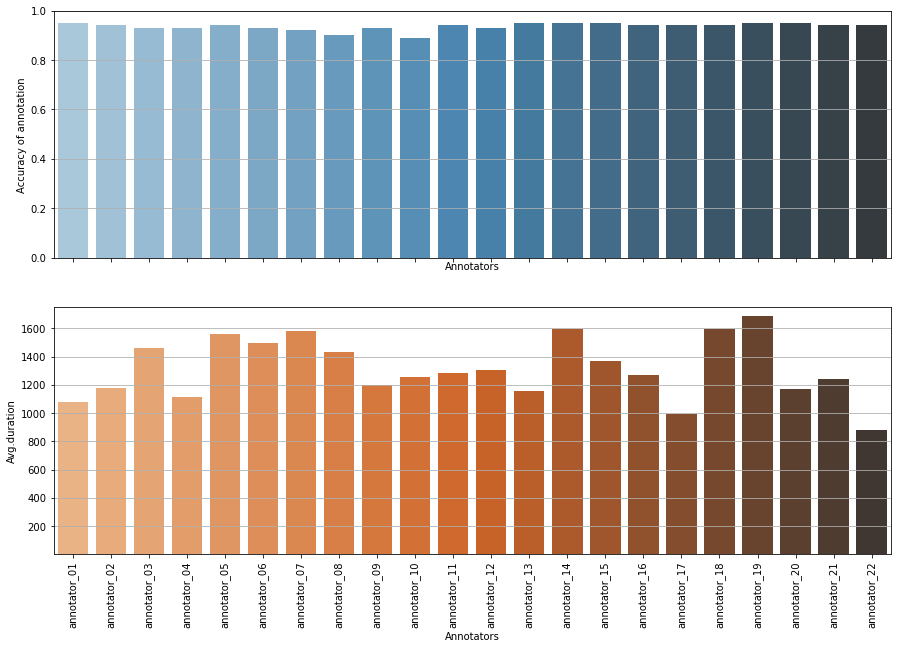

In [44]:
# visualize the accuracy and avg. annotation time by each annotator
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,10))

#ax[0].set_title("Accuracy", y=1.05, size=15)
sns.barplot(x='user', y='accuracy', data=stats_user, palette='Blues_d', ax=ax[0])
ax[0].set_ylabel('Accuracy of annotation', fontsize=10)
ax[0].set_xlabel('Annotators', fontsize=10)
ax[0].xaxis.set_tick_params(rotation=90)
ax[0].set_ylim([0, 1])
ax[0].grid(axis='y')

#ax[1].set_title("Avg.duration", y=1.05, size=15)
sns.barplot(x='user', y='avg.duration', data=stats_user, palette='Oranges_d', ax=ax[1])
ax[1].set_ylabel('Avg.duration', fontsize=10)
ax[1].set_xlabel('Annotators', fontsize=10)
ax[1].xaxis.set_tick_params(rotation=90)
ax[1].set_ylim([1, 1750])
ax[1].grid(axis='y')

plt.show()


In [45]:
# find out annotator with high accuracy and low avg.duration
accu_q1 = stats_user['accuracy'].quantile(q=0.25)
accu_q3 = stats_user['accuracy'].quantile(q=0.75)
dura_q1 = stats_user['avg.duration'].quantile(q=0.25)
dura_q3 = stats_user['avg.duration'].quantile(q=0.75)
top_users = stats_user.loc[(stats_user['accuracy']>=accu_q3) & (stats_user['avg.duration']<=dura_q1)]
bad_users = stats_user.loc[(stats_user['accuracy']<=accu_q1) & (stats_user['avg.duration']>=dura_q3)]


print("Annotators, who had high accuracy and took low avg.annotation time are good.\n", list(top_users['user']))
print("Annotators, who had low accuracy and took long avg.annotation time are bad.\n", list(bad_users['user']))

Annotators, who had high accuracy and took low avg.annotation time are good.
 ['annotator_01', 'annotator_13', 'annotator_20']
Annotators, who had low accuracy and took long avg.annotation time are bad.
 ['annotator_06', 'annotator_07']


In [46]:
print(top_users)

            user  total amount  positive amount  correct amount  avg.duration  \
0   annotator_01          1280              673            1214       1077.32   
12  annotator_13          7078             3497            6702       1155.01   
19  annotator_20          6125             3048            5809       1173.21   

    accuracy  precision  recall  
0       0.95       0.94    0.96  
12      0.95       0.95    0.94  
19      0.95       0.95    0.95  


In [47]:
print(bad_users)

           user  total amount  positive amount  correct amount  avg.duration  \
5  annotator_06          5336             2901            4945       1496.94   
6  annotator_07          2174             1130            1990       1578.35   

   accuracy  precision  recall  
5      0.93       0.90    0.96  
6      0.92       0.91    0.93  


************************

### Recycle Bin

##### Tester crowd_extractor
```python
testinfo = crowd_extractor(crowds['7e8984b6-dff7-4015-865a-b721a2faf681'])
'''
testinfo = pd.DataFrame(
    testinfo, columns=[
        'image','user','answer','solvable','corrupt','duration'
    ]
)
'''
testinfo
```

##### Tester statistics
```python
#inst='image'
inst='user'

ll = list(set(data[inst]))
nn = np.random.randint(0, len(ll)+1)
print("instance: ", ll[nn])

nna = list(data[inst]).count(ll[nn])
print("amount answer: ", nna)

nnp = list(data['answer'].loc[data[inst]==ll[nn]]).count(1)
print("positive answer: ", nnp)

nnc = list(data['correct'].loc[data[inst]==ll[nn]]).count(1)
print("right answer: ", nnc)

accu = np.mean(list(data['correct'].loc[data[inst]==ll[nn]]))
print("accuracy: {}%".format(round(accu*100, 2)))

n_tp = len(data_fix[(data_fix['reference']==1) & (data_fix['answer']==1)].loc[data_fix['user']=='annotator_06'])

prec = n_tp/len(data_fix[(data_fix['answer']==1)].loc[data_fix['user']=='annotator_06'])

rec = n_tp/len(data_fix[(data_fix['reference']==1)].loc[data_fix['user']=='annotator_06'])

np.mean(data_fix['reference'].loc[data_fix['image']=='img_8292'])

data.loc[data[inst]==ll[nn]]
```

##### prototype of statistic_master (not used)
```python
# count the amount of results for each annotator
def count_results(df=data, col='user', sort=True):
    amounts = []   
    # deduplication of chosen column and sort 
    inst_list = list(set(df[col]))
    if sort == True:
        inst_list.sort()
    
    for inst in inst_list:
        amounts.append(list(df[col]).count(inst))        
    # save in DataFrame
    result = pd.DataFrame(
        amounts, 
        columns=['amounts'], 
        index=inst_list
    )
    
    return result

count = count_results()
print("The amounts of results produced by every annotators:\n", count)
```

##### Tester DataFrame
```python
df1=pd.DataFrame([[1,2,3],[4,5,6],[7,8,9]], columns=['co1','co2','co3'])
l4 = [4,4,4]
l5 = [5,5,5]
l6 = ['yes','no','']
df1['co4'] = l4
df1 = df1.assign(co5=l5, co6=l6)
num_encode = {'co6' : {'yes':1, 'no':0, '':np.nan}}
df1.replace(num_encode, inplace=True)
df1
```

##### Transfer 'yes/no' to '1/0', NaN if no answer
```python
def answer_transfer(ans):
    if str(ans).lower() == 'yes':
        new_ans = int(1)
    elif str(ans).lower() == 'no':
        new_ans = int(0)
    else:
        new_ans = np.nan
        
    return new_ans
```

##### Tester add reference column
```python
# add column of references for images
stat_image['reference'] = stat_image.apply(
    lambda x: int(ref[x[0]]['is_bicycle']), 
    axis=1
)
```

#### Get statistical information by annotator or images/questions (old version)
```python
def statistic_master(df=data_fix, col='user', sort=True):
    start = time()
    '''
    This function is used to get statistic information from the data set, like:
        - amount of annotations by selected category
        - amount of positive annotations
        - amount of correct annotations
        - accuracy of annotation by selected category
        - average duration
        - precision
        - recall
    Argument col could take 'user' or 'image'
    The output is a pandas.DataFrame.
    '''
    amounts = []
    pos = []
    corr = []
    accu = []
    dura = []
    ref = []
    preci = []
    rec = []
    
    # deduplication of chosen column and sort 
    inst_list = list(set(df[col]))
    if sort == True:
        inst_list.sort()
    
    total = len(inst_list)
    i = 0
    for inst in inst_list:
        i += 1
        percent = round(1.0 * i / total * 100, 2)
        
        n_tp = len(df[(df['answer']==1) & (df['reference']==1)].loc[df[col]==inst])
        
        # collect the statistic informations
        amounts.append(
            list(df[col]).count(inst)
        )
        pos.append(
            list(df['answer'].loc[df[col]==inst]).count(1)
        )
        corr.append(
            list(df['correct'].loc[df[col]==inst]).count(1)
        )
        accu.append(
            round(np.mean(df['correct'].loc[df[col]==inst]), 2)
        )
        dura.append(
            round(np.mean(df['duration'].loc[df[col]==inst]), 2)
        )
        ref.append(
            int(np.mean(df['reference'].loc[df[col]==inst]))
        )
        if col=='user':
            preci.append(
                round(n_tp/len(df[(df['answer']==1)].loc[df[col]==inst]), 2)
            )
            rec.append(
                round(n_tp/len(df[(df['reference']==1)].loc[df[col]==inst]), 2)
            )
        print(
            "Processing: {0}, {1} [{2}/{3}]".format(inst, str(percent)+'%', i, total), 
            end="\r"
        )
        #time.sleep(0.01)
    print("Processing done! {:.2f} seconds passed.".format((time() - start)), end="\r")
        
    # save in DataFrame
    result = pd.DataFrame(
        {
            'instance': inst_list,
            'total': amounts,
            'duration': dura,
            'positive': pos,
            'correct': corr,
            'accuracy': accu
        }
    )
    '''
    # add percent sign
    result.loc[:, 'accuracy'] = result.loc[:, 'accuracy'].apply(
        lambda x: "{:.2f}%".format(x)
    )
    '''
    if col=='user':
        result = result.assign(
            precision = preci,
            recall = rec
        )
    if col=='image':
        result['reference'] = ref
        
    return result
```

#### Verified precision and recall with scikit-learn
```python
inst='user'
ul = list(set(data_fix[inst]))
nn = np.random.randint(0, len(ul))
print("instance: ", ul[nn])

y_pred = list(data_fix['answer'].loc[data_fix[inst]==ul[nn]])
y_true = list(data_fix['reference'].loc[data_fix[inst]==ul[nn]])

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
accu = (tp+tn)/(tn+fp+fn+tp)

print("accuracy:", accu)
print("precision:", prec)
print("recall:", rec)
```